 # DATA ANALYSIS


In [404]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

### Acquiring data

In [405]:
data = pd.read_csv("data/responses.csv")

Quick look at how the data is composed.

In [406]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Columns: 150 entries, Music to House - block of flats
dtypes: float64(134), int64(5), object(11)
memory usage: 1.2+ MB


### Target variable

Let's see which values is the target variable composed of.

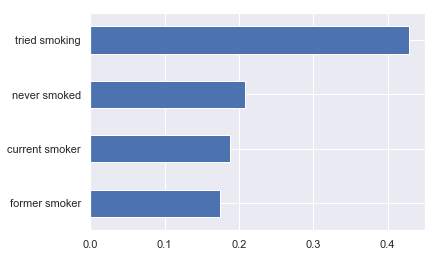

In [407]:
data["Smoking"].value_counts(normalize=True).sort_values().plot(kind='barh');

We are trying to determine if a person has been a smoker during a period of his life. For this reason, we group together  'never smoked' and 'tried smoking' under the label 'No' (0), while 'former smoker' and 'current smoker' are grouped under the label 'Yes' (1).

In [408]:
data["Smoker"] = data["Smoking"].map({
    "never smoked": "No", 
    "tried smoking": "No", 
    "former smoker": "Yes", 
    "current smoker": "Yes"})
data.drop("Smoking", axis=1, inplace=True)

Let's see how the target variable is now composed.

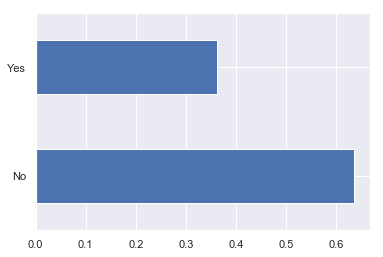

In [409]:
data["Smoker"].value_counts(normalize=True).plot(kind='barh');

How many missing values does the target variable have?

In [410]:
print("Number of missing values in target: %d" % data["Smoker"].isnull().sum())

Number of missing values in target: 8


In the rows with a missing value for the target variable "Smoker", which other values are missing?

Row 130 - Missing:  Documentary - Alcohol - Smoker - 
Row 149 - Missing:  Smoker - 
Row 525 - Missing:  Fun with friends - Friends versus money - Hypochondria - Smoker - 
Row 567 - Missing:  Documentary - Biology - Giving - Charity - Spending on looks - Smoker - 
Row 629 - Missing:  Alcohol - Healthy eating - Smoker - 
Row 708 - Missing:  Alcohol - Healthy eating - Smoker - 
Row 763 - Missing:  Geography - Smoker - 
Row 980 - Missing:  Passive sport - Smoker - 


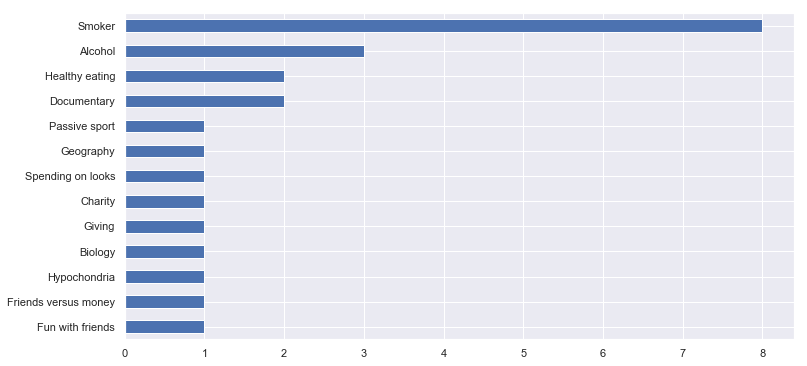

In [411]:
values_missing = dict()
for index, row in data[data["Smoker"].isnull()].iterrows():
    print("Row %d - Missing: "% index, end=" ")
    for col in row[row.isnull()].index:
        print(col, end=" - ")
        if col in values_missing:
            values_missing[col] += 1
        else:
            values_missing[col] = 1
    print()

s = pd.Series(values_missing).sort_values()
s.plot(kind='barh', figsize=(12,6));

Interesting to notice:
- Three people that chose to not indicate their smoking habits also avoided talking about alcohol consumption.
- Two of them also avoided talking about health habits.

We remove the rows with missing values for the target variable.

In [412]:
data = data.drop(data[data["Smoker"].isnull()].index)
print("Number of missing values in target: %d" % data["Smoker"].isnull().sum())

Number of missing values in target: 0


## Data visualization

Let's look at two features that will be interesting later, 'Alcohol' and 'Gender', and their relation to the target variable.

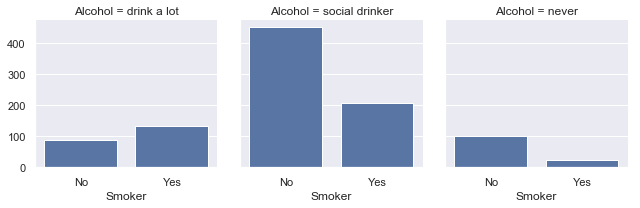

In [413]:
g = sns.FacetGrid(data, col="Alcohol")
g.map(sns.countplot, "Smoker");

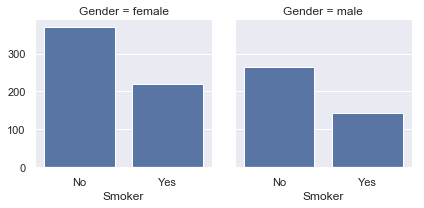

In [414]:
g = sns.FacetGrid(data, col="Gender")
g.map(sns.countplot, "Smoker");

And what about 'Age'?

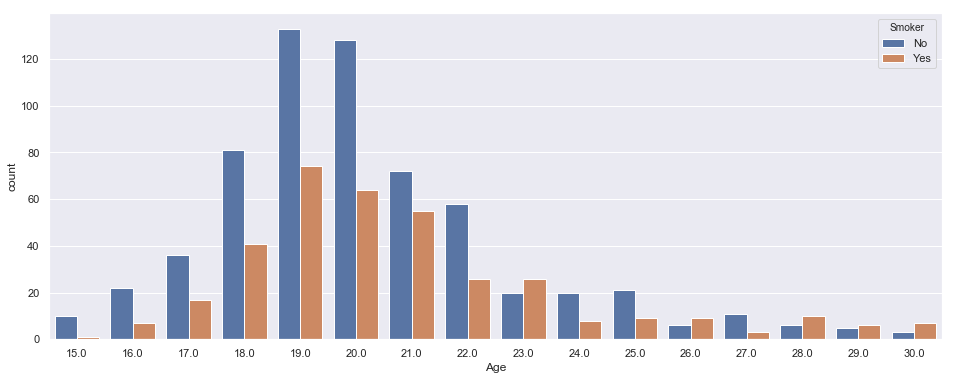

In [415]:
sns.set(rc={'figure.figsize':(16,6)})
sns.countplot(data=data, x="Age", hue="Smoker");

# data_plot = data.groupby(['Smoker', 'Age']).size().reset_index().pivot(columns='Smoker', index='Age', values=0)
# data_plot.sort_index(ascending=False).plot(kind='barh', figsize=(14,7), stacked=True);

### Encoding of categorical variables

We have to transform the categorical variables into numerical ones.

In [416]:
data.describe(exclude=np.number)

,Alcohol,Punctuality,Lying,Internet usage,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats,Smoker
count,1000,1000,1000,1002,996,999,1001,1000,998,998,1002
unique,3,3,4,4,2,2,6,2,2,2,2
top,social drinker,i am always on time,sometimes,few hours a day,female,right handed,secondary school,no,city,block of flats,No
freq,658,396,544,737,589,899,617,747,702,590,638


In [417]:
data["Alcohol"] = data["Alcohol"].map({"never": 0, "social drinker": 1, "drink a lot": 2})

data["Punctuality"] = data["Punctuality"].map({"i am often early": 0, "i am always on time": 1, "i am often running late": 2})

data["Lying"] = data["Lying"].map({"never": 0, "sometimes": 1, "only to avoid hurting someone": 2, "everytime it suits me": 3})

data["Internet usage"] = data["Internet usage"].map({
    "no time at all": 0, 
    "less than an hour a day": 1, 
    "few hours a day": 2, 
    "most of the day": 3})

data["Female"] = data["Gender"].map({"male": 0, "female": 1})
data.drop("Gender", axis=1, inplace=True)

data["Right handed"] = data["Left - right handed"].map({"left handed": 0, "right handed": 1})
data.drop("Left - right handed", axis=1, inplace=True)

data["Education"] = data["Education"].map({
    "currently a primary school pupil": 0,
    "primary school": 1, 
    "secondary school": 2, 
    "college/bachelor degree": 3, 
    "masters degree": 4,
    "doctorate degree": 5})

data["Only child"] = data["Only child"].map({"no": 0, "yes": 1})

data["Living in a city"] = data["Village - town"].map({"village": 0, "city": 1})
data.drop("Village - town", axis=1, inplace=True)

data["Living in a flat"] = data["House - block of flats"].map({"house/bungalow": 0, "block of flats": 1})
data.drop("House - block of flats", axis=1, inplace=True)

data["Smoker"] = data["Smoker"].map({"No": 0, "Yes": 1})

### Correlation

What are the features most heavily correlated with each others?

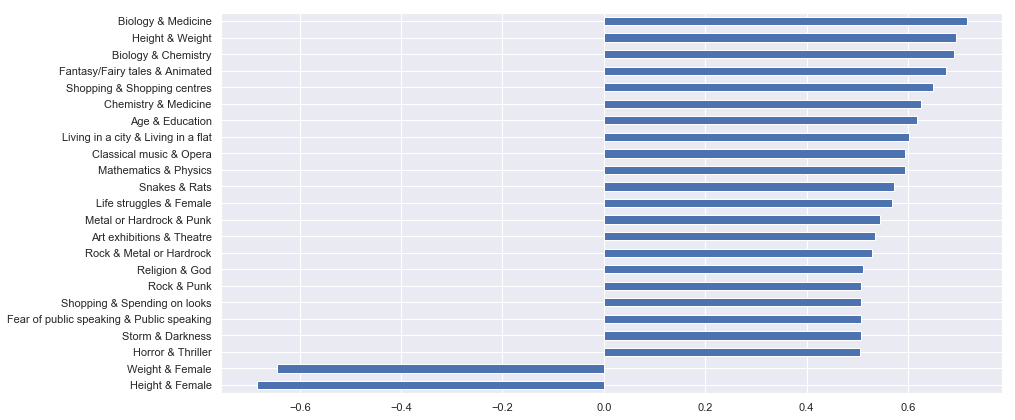

In [418]:
corr = data.corr()
ord_corr = dict()

# Saving heavily correlated features in a dictionary.
for row in range(corr.shape[0]):
    for col in range(corr.iloc[row].shape[0]):
        if abs(corr.iloc[row][col]) > 0.5 and row < col:
            key = corr.index[row] + " & " + corr.index[col]
            ord_corr[key] = corr.iloc[row][col]

# Plotting
pd.Series(ord_corr).sort_values().plot(kind='barh', figsize=(14,7));

Which features are more correlated with our target variable?

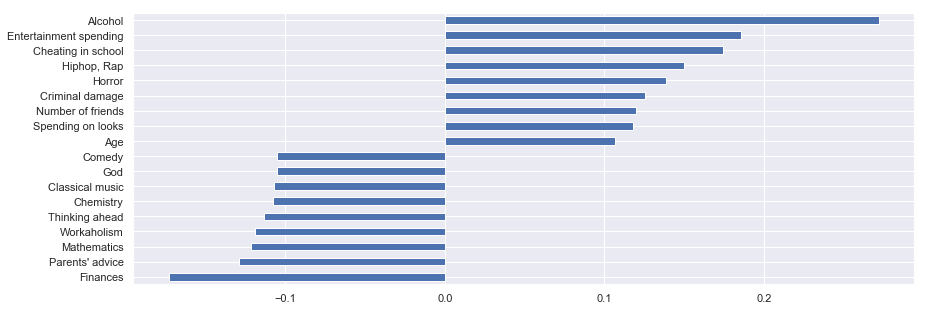

In [419]:
corr_target = corr["Smoker"]
corr_target = corr_target.sort_values()
corr_target = corr_target.drop("Smoker")

# Selection of the most correlated features.
relevant_features = corr_target[abs(corr_target)>0.1]
relevant_features.plot(kind='barh', figsize=(14,5));

We can observe that 'Alcohol' has the highest correlation value (0.27), which is consistent with what we saw before during data visualization.

#### An odd fact

While looking at these numbers, I noticed something odd. It is popular knowledge that men are usually more inclined to smoking than women, but this does not show in our dataset.

In [420]:
print("Correlation between 'Gender' and 'Smoker': %.3f" % (corr_target['Female']))

Correlation between 'Gender' and 'Smoker': 0.023


Actually, considering both positive and negative coefficients, 'Female' is only the 120th highest correlated feature! 

In [421]:
abs_corr_target = corr_target.abs().sort_values(ascending=False)
abs_corr_target.index.get_loc("Female")

120

After some research, I found out that in Slovakia, the country where the survey that generated the dataset took place, [39.7%](https://tradingeconomics.com/slovakia/smoking-prevalence-males-percent-of-adults-wb-data.html) of the men were smokers during 2015, while only [17.6%](https://tradingeconomics.com/slovakia/smoking-prevalence-females-percent-of-adults-wb-data.html) of females were smokers.

Are those relative percentages respected in our dataset?

In [422]:
smokers_by_gender = data.groupby("Female").mean()["Smoker"]
print("In our dataset %.1f%% of men are smokers." % (smokers_by_gender[0]*100))
print("In our dataset %.1f%% of women are smokers." % (smokers_by_gender[1]*100))

In our dataset 35.1% of men are smokers.
In our dataset 37.4% of women are smokers.


It is utterly striking to notice that 37.3% of the women that took the survey affirmed to be smokers, a number that is higher than the men's one and more than double than the one reported as the national average!

This may be due to the limited size of the sample. It is a shame, because an higher correlation between this feature and the target could have greatly helped improving the accuracy of our models.

# Missing values

Let's check how many missing values are in the data set and how can we deal with them.

In [423]:
data_na = round((data.isnull().sum() / len(data)) * 100, 3)
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({"Missing": data.isnull().sum(),  "%": data_na}).sort_values(by="%", ascending=False)[:30]
missing_data.head(10)

,Missing,%
Weight,20,1.996
Height,20,1.996
Passive sport,14,1.397
Chemistry,10,0.998
Punk,8,0.798
Theatre,8,0.798
Latino,8,0.798
Geography,8,0.798
Alternative,7,0.699
Age,7,0.699


Text(0.5, 1.0, 'Top Variables for % of Missing Values')

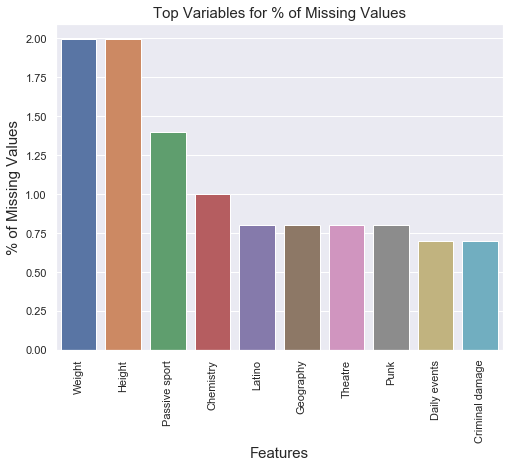

In [424]:
f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index[:10], y=data_na[:10])
plt.xlabel('Features', fontsize=15)
plt.ylabel('% of Missing Values', fontsize=15)
plt.title('Top Variables for % of Missing Values', fontsize=15)

We search for the features that have a high correlation with 'Weight' and 'Height'. What we find is not a surprise.

In [425]:
corr_weight = corr["Weight"].sort_values(ascending=False)
imp_corr_weight = corr_weight[corr_weight.abs() > 0.4]
imp_corr_weight

Weight    1.000000
Height    0.695696
Female   -0.644266
Name: Weight, dtype: float64

We try to impute the missing values for these features by using what we just discovered.

In [426]:
# Filling missing value of Weight with the median weight of similar rows according to Height and Female
index_NaN_weight = list(data["Weight"][data["Weight"].isnull()].index)

for i in index_NaN_weight:
    weight_med = data["Weight"].median()
    weight_pred = data["Weight"][((data['Height'] == data.iloc[i]["Height"]) & (data['Female'] == data.iloc[i]["Female"]))].median()
    if not np.isnan(weight_pred) :
        data['Weight'].iloc[i] = weight_pred
    else:
        data['Weight'].iloc[i] = weight_med

In [427]:
# Filling missing value of Height with the median weight of similar rows according to Weight and Female
index_NaN_height = list(data["Height"][data["Height"].isnull()].index)

for i in index_NaN_height:
    height_med = data["Height"].median()
    height_pred = data["Height"][((data['Weight'] == data.iloc[i]["Weight"]) & (data['Female'] == data.iloc[i]["Female"]))].median()
    if not np.isnan(height_pred) :
        data['Height'].iloc[i] = height_pred
    else:
        data['Height'].iloc[i] = height_med

We substitute the remaining missing values with the most frequent value in their column.

In [428]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [429]:
data = pd.DataFrame(data=imp.fit_transform(data), columns=data.columns, index=data.index)
print("Missing values: %d" % (data.isnull().sum().sum()))

Missing values: 0


### Outliers detection

There are probably not going to be a lot of features prone to outliers, given that most of them have values ranging only from 1 to 5. Two of the most prone ones are, again, 'Weight' and 'Height'. Let's visualize them.

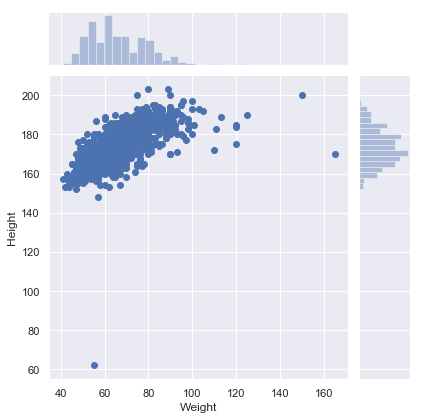

In [430]:
sns.jointplot(x='Weight', y='Height', data=data);

Let's have a closer look to the 'Weight' outliers. We plot them with 'Age'.

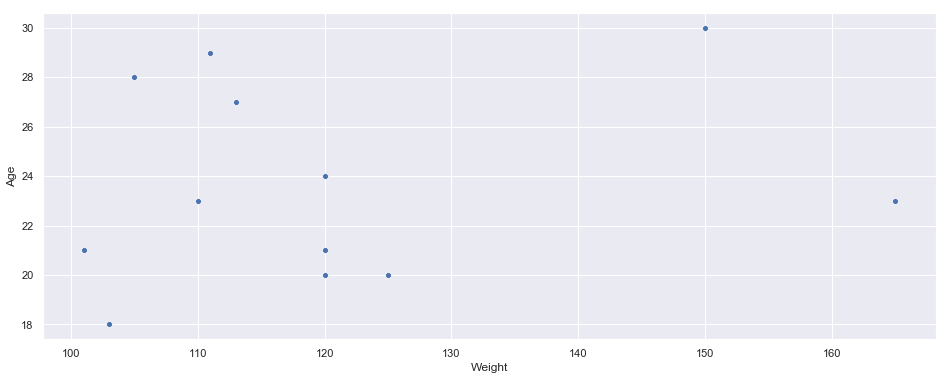

In [431]:
sns.scatterplot(x="Weight", y="Age", data=data[data["Weight"] > 100]);

There is not much that we can say about these outliers. They are feasible values, so we leave them be.

But what about that lonely 'Height' value?

In [432]:
data.loc[data["Height"] < 100, ['Female', 'Age', 'Height', 'Weight', 'Smoker']]

,Female,Age,Height,Weight,Smoker
676,1.0,20.0,62.0,55.0,1.0


The 'Height' outlier is certainly a mistake made compiling the survey, probably it was meant to be 162. So we fix it.

In [433]:
data.loc[676, 'Height'] = 162

### Binning of continuous variables

Binning refers to dividing a list of continuous variables into groups.
We bin values of 'Age', 'Weight' and 'Height' in order to improve the accuracy of the models.

In [434]:
# Continuous variable bins, we found that 5, 6, 6 are the optimal numbers in this case.
data['AgeBin'] = pd.cut(data['Age'], 5)
data['HeightBin'] = pd.qcut(data['Height'].astype(int), 6)
data['WeightBin'] = pd.qcut(data['Weight'].astype(int), 6)

# Convert objects to categories.
data['Age'] = LabelEncoder().fit_transform(data['AgeBin'])
data['Height'] = LabelEncoder().fit_transform(data['HeightBin'])
data['Weight'] = LabelEncoder().fit_transform(data['WeightBin'])

# Drop unnecessary features.
drop_features = ['AgeBin', 'HeightBin', 'WeightBin']
data = data.drop(drop_features, axis=1)

Now we save the cleaned data into a file, ready to be used for modeling.

In [435]:
data.to_csv("data/clean_data.csv", index=False)